<a href="https://colab.research.google.com/github/aravndr/colab-deeplearning/blob/main/BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
keras.utils.set_random_seed(42)

In [4]:
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

In [5]:
df.shape

(303, 14)

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [7]:
df.target.value_counts(normalize=True, dropna=False)

,proportion
target,
0,0.726073
1,0.273927


In [9]:
df.target.value_counts(normalize=True)

,proportion
target,
0,0.726073
1,0.273927


In [10]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg','exang', 'ca', 'thal']
numerics = ['age', 'trestbps','chol', 'thalach', 'oldpeak', 'slope']

NNs require all their inputs to be numeric so we will first preprocess this raw data as follows:

one-hot encode the categorical variables
normalize the numeric variables
With the pandas get_dummies function, you can one-hot-encode in one line.

In [11]:
df = pd.get_dummies(df, columns = categorical_variables)

In [12]:
df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,63,145,233,150,2.3,3,0,False,True,False,...,False,True,False,False,False,False,False,True,False,False
1,67,160,286,108,1.5,2,1,False,True,False,...,True,False,False,False,True,False,False,False,True,False
2,67,120,229,129,2.6,2,0,False,True,False,...,True,False,False,True,False,False,False,False,False,True
3,37,130,250,187,3.5,3,0,False,True,False,...,False,True,False,False,False,False,False,False,True,False
4,41,130,204,172,1.4,1,0,True,False,False,...,False,True,False,False,False,False,False,False,True,False


NNs work best when the inputs are all roughly in the same range. So standard practice is to standardize the numeric variables.

Before we do so, let's split the data into an 80% training set and 20% test set

In [13]:
test_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(test_df.index)

In [14]:
train_df.shape

(242, 30)

In [15]:
test_df.shape

(61, 30)

In [16]:
means = train_df[numerics].mean()
sd = train_df[numerics].std()

In [17]:
means

,0
age,54.268595
trestbps,131.995868
chol,246.512397
thalach,149.805785
oldpeak,1.032645
slope,1.590909


standardize the train and test dataframes with these means and standard deviations.

In [18]:
train_df[numerics]= (train_df[numerics] - means)/sd

In [19]:
test_df[numerics]= (test_df[numerics] - means)/sd

In [20]:
train_df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,0.963746,0.721939,-0.278690,0.008396,1.083461,2.226814,0,False,True,False,...,False,True,False,False,False,False,False,True,False,False
1,1.405254,1.554681,0.814423,-1.807247,0.399542,0.646494,1,False,True,False,...,True,False,False,False,True,False,False,False,True,False
2,1.405254,-0.665964,-0.361189,-0.899426,1.339930,0.646494,0,False,True,False,...,True,False,False,True,False,False,False,False,False,True
3,-1.906055,-0.110803,0.071931,1.607891,2.109339,2.226814,0,False,True,False,...,False,True,False,False,False,False,False,False,True,False
4,-1.464547,-0.110803,-0.876809,0.959447,0.314052,-0.933825,0,True,False,False,...,False,True,False,False,False,False,False,False,True,False


Now data is entirely numeric. To feed data to Tensorflow, convert to numpy arrays

In [21]:
train = train_df.to_numpy()
test = test_df.to_numpy()

Final step: Our features $X$ and dependent variable $y$ are both inside the `train` and `test` arrays so let's separate them out.


In [22]:
train_X = np.delete(train, 6, axis=1)
test_X = np.delete(test, 6, axis=1)

In [24]:
train_X.shape, test_X.shape

((242, 29), (61, 29))

select just the 6th column and define the train and test  𝑦  variables.

In [25]:
train_y = train[:, 6]
test_y = test[:, 6]

In [26]:
train_y.shape, test_y.shape

((242,), (61,))

Build a model now. Single hidden layer. Since it's binary classification problem, we will use a sigmoid activation in the output layer

In [31]:
num_columns = train_X.shape[1]

# define the input layer
input = keras.Input(shape=(num_columns,))

#feed the input vector to the hidden layer
#optional: you can give names to each layer

h = keras.layers.Dense(16, activation='relu', name='Hidden')(input)

#feed the output of the hidden layer to the output layer
output = keras.layers.Dense(1, activation='sigmoid', name='Output')(h)

#tell Keras that this (input,output) pair is the model
model = keras.Model(input, output)

In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden (Dense)                  │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

Hand calculate the number of parameters

In [33]:
(29 + 1)* 16 + (16 + 1) * 1

497

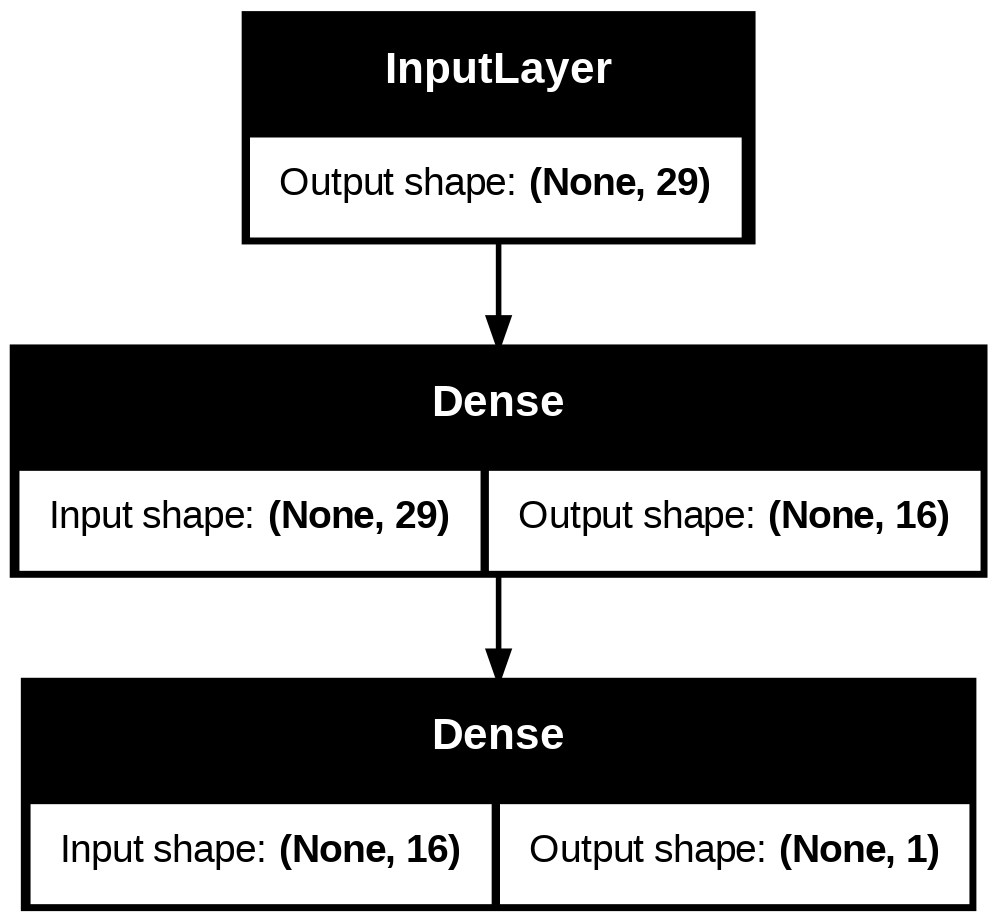

In [34]:
keras.utils.plot_model(model, show_shapes=True)

Set optimization parameters
Since our output variable is binary, we will select the binary_crossentropy loss function.
Optimizer to use - we will use a sibling of SGD called Adam which is an excellent default choice
In classification problems like this one, Accuracy is usually the metric you want to see.

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [35]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss= "binary_crossentropy", metrics=["accuracy"])

Train the model.
Batch size = 32 is a good default
Numbof of epochs. Number of passes through the training data. Usually 20-30 epochs is good starting point, but since the dataset is very small, lets run it for 300 epochs. It will allow us to see if any overfitting happens
Lets use 20% of data as a validation set so it will be useful for overfitting detection and regularization via early stoppy

In [37]:
history = model.fit(train_X.astype(np.float32), #the array with the input X columns
                    train_y.astype(np.float32), # the array with the output y column
                    epochs=300, #number of epochs to run
                    batch_size=32,  #number of samples (ie datapoints per bactch)
                    verbose=1, #verbosity during training
                    validation_split=0.2) #fraction of data to be used as validation set

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5511 - loss: 0.7246 - val_accuracy: 0.5918 - val_loss: 0.6891
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6019 - loss: 0.6898 - val_accuracy: 0.6122 - val_loss: 0.6697
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6082 - loss: 0.6660 - val_accuracy: 0.6122 - val_loss: 0.6530
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6477 - loss: 0.6450 - val_accuracy: 0.6122 - val_loss: 0.6372
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6715 - loss: 0.6256 - val_accuracy: 0.6531 - val_loss: 0.6225
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7010 - loss: 0.6072 - val_accuracy: 0.6939 - val_loss: 0.6088
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7350 - loss: 0.5902 - val_accuracy: 0.6939 - val_loss: 0.5959
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7517 - loss: 0.5743 - val_accuracy: 0.7143 - val_loss:

Plot metrics like loss and accuracy as a function of the #epochs to understand how training has progressed

In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

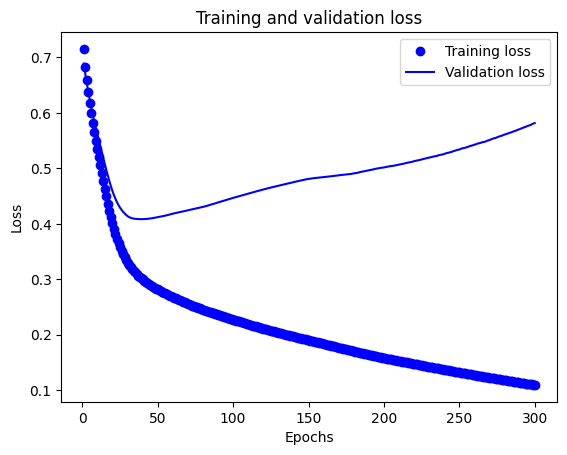

In [39]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Let's look at the accuracy curves as well.

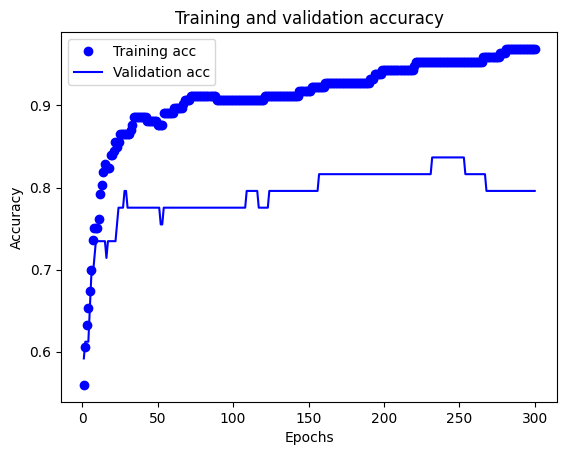

In [40]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

how well the model does on the test set.

model.evaluate is a very handy function to calculate the performance of your model on any dataset.

In [42]:
model.evaluate(test_X.astype(np.float32), test_y.astype(np.float32))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8490 - loss: 0.4713


[0.4810093939304352, 0.8360655903816223]